#### Instructions:
- Data can be downloaded [here](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)
- Make sure the data is stored in folder *Data* in same directory as this notebook 
- Python libraries are a part of the Anaconda distribution, except mlxtend (pip install mlxtend)
- When using full dataset for ratings you need large RAM, especially because of apriori algorithm
- Run cells sequentially (or press Run All)

# Recommender System

In [1]:
## Installs
#%pip install mlxtend

## Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import ast
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse.linalg import norm

## Loading data and preliminary preprocess

In [2]:
## Load data

ratings = pd.read_csv("Data/ratings_small.csv")
movies = pd.read_csv("Data/movies_metadata.csv", usecols=['genres', 'id', 'original_language', 'overview',
                       'popularity', 'title'], low_memory=False)
links = pd.read_csv("Data/links_small.csv")
keywords = pd.read_csv('Data/keywords.csv')
credits = pd.read_csv('Data/credits.csv')

In [3]:
## Preprocess credits

# id to integer
credits['id'] = pd.to_numeric(credits['id'])
credits.drop_duplicates('id', inplace=True)

# String to list
credits['cast'] = credits['cast'].apply(lambda x: ast.literal_eval(x))
credits['crew'] = credits['crew'].apply(lambda x: ast.literal_eval(x))

In [4]:
## Preprocess keywords

# id to integer
keywords['id'] = pd.to_numeric(keywords['id'])
keywords.drop_duplicates('id', inplace=True)

# String to list
keywords['keywords'] = keywords['keywords'].apply(lambda x: ast.literal_eval(x))

In [5]:
## Preprocess links

# When reading missing tmdbId values they are set to nan and rest to float
#  -> drop those rows and set tmdbId to int
links.dropna(subset=['tmdbId'], inplace=True)
links.reset_index(inplace=True, drop=True)
links['tmdbId'] = links['tmdbId'].astype(int)

In [6]:
## Preprocess ratings

# Drop timestamp
ratings.drop('timestamp', axis=1, inplace=True)

In [7]:
## Preprocess movies metadata (first need to load data)

# String to list
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x))

# id to integer
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')   # Non numeric values set to nan
movies.dropna(subset=['id'], inplace=True)   # Drop those nan rows
movies.reset_index(inplace=True, drop=True)
movies['id'] = movies['id'].astype(int)   # Set id to type int
movies.drop_duplicates('id', inplace=True)

# Mismatch between tmdbId and movieId
links.drop_duplicates('tmdbId', inplace=True)
links.drop_duplicates('movieId', inplace=True)

In [8]:
## Make sure all df contain the same set of ids

rating_ids = links[ links['movieId'].isin(ratings['movieId']) ]['tmdbId'].values
keep_ids = set(rating_ids) & set(movies['id'].values) & set(keywords['id'].values) & set(credits['id'].values)

movies = movies[ movies['id'].isin(keep_ids) == True ]
links = links[ links['tmdbId'].isin(keep_ids) == True ]
ratings = ratings[ ratings['movieId'].isin(links['movieId']) == True ]
keywords = keywords[ keywords['id'].isin(keep_ids) == True ]
credits = credits[ credits['id'].isin(keep_ids) == True ]

# Sanity check
print('#Movies in movies', len(movies['id'].unique()))
print('#Movies in ratings', len(ratings['movieId'].unique()))
print('#Movies in links', len(links['tmdbId'].unique()))
print('#Movies in keywords', len(keywords['id'].unique()))
print('#Movies in credits', len(credits['id'].unique()))

#Movies in movies 9025
#Movies in ratings 9025
#Movies in links 9025
#Movies in keywords 9025
#Movies in credits 9025


In [9]:
## Map tmdbId in movies to movieId, and id in keywords and credits to movieId by using links

links_dict = dict(zip(links['tmdbId'], links['movieId']))
movies['movieId'] = movies['id'].apply(lambda x: links_dict[x])
keywords['movieId'] = keywords['id'].apply(lambda x: links_dict[x])
credits['movieId'] = credits['id'].apply(lambda x: links_dict[x])

In [10]:
## We note that movieId in ratings are not consecutive integers so we change that for simplicity with 
## slicing and such.
## We do the same for userId even tough they are consecuative, only for slicing convenience setting first
## user with id 0 instead of 1.

def convert_ids(values):
 # Convert ids to consecutive integers (start from 0 for convenience)
 newIds = {}
 count = 0
 for i in values:
    if i not in newIds:
        newIds[i] = count
        count += 1
 return newIds

# Consecutive movieId starting from 0
newIds = convert_ids(movies['movieId'].values)
ratings['movieId'] = ratings['movieId'].apply(lambda x: newIds[x])
movies['movieId'] = movies['movieId'].apply(lambda x: newIds[x])
links['movieId'] = links['movieId'].apply(lambda x: newIds[x])
keywords['movieId'] = keywords['movieId'].apply(lambda x: newIds[x])
credits['movieId'] = credits['movieId'].apply(lambda x: newIds[x])

# Consecutive userId starting form 0
ratings['userId'] = ratings['userId'].apply(lambda x: x-1)

# Sort by movieId and reset index so that indexing is easy
movies.sort_values(by=['movieId'], inplace=True)
movies.reset_index(inplace=True, drop=True)
keywords.sort_values(by=['movieId'], inplace=True)
keywords.reset_index(inplace=True, drop=True)
credits.sort_values(by=['movieId'], inplace=True)
credits.reset_index(inplace=True, drop=True)

In [11]:
## Free memory
del keep_ids, links_dict, newIds, rating_ids

## Data exploratory

In [12]:
## Bit of data exploratory:
## - find sensible threshold for highly rated movies
## - do we need to drop users?
## - general information about the data

count    99810.000000
mean         3.542972
std          1.057939
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

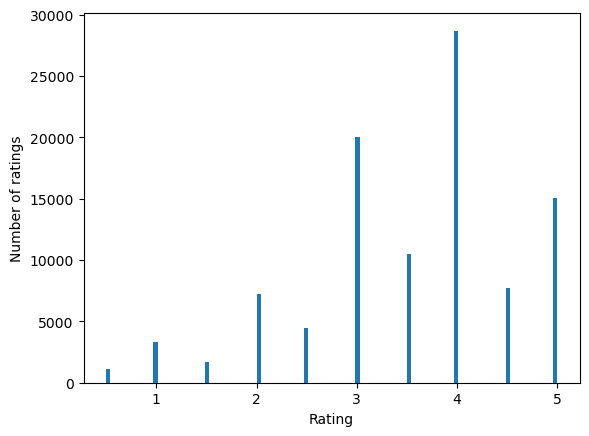

In [13]:
# Summary statistics for the ratings
display(ratings['rating'].describe())

# Histogram of ratings
ratings.hist('rating', bins='auto', grid=False)
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('')
plt.show()

Number of unique movies:  9025
Average number of ratings per movie: 11.1


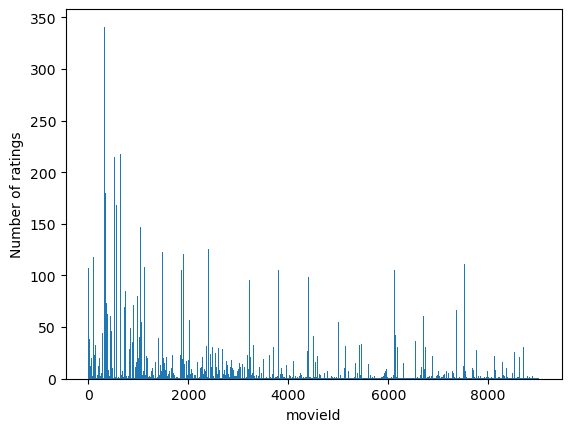

Number of unique movies for high ratings:  6141
Average number of ratings per movie for high ratings: 8.4


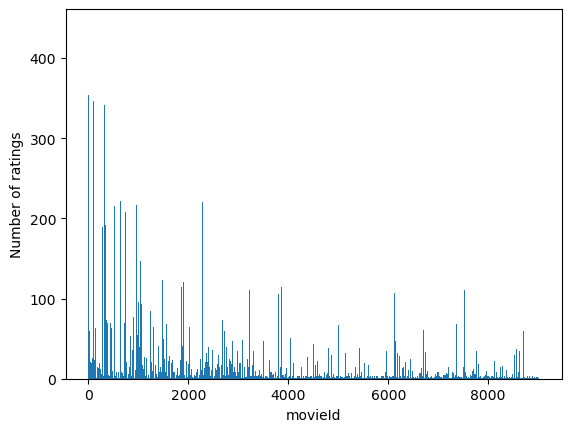

Number of unique users:  671
Average number of ratings per users: 148.7


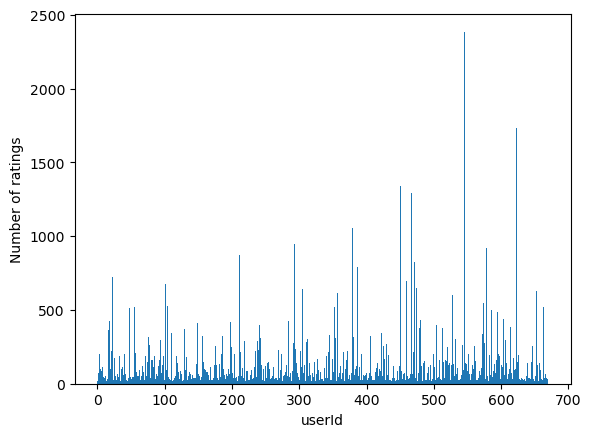

Number of unique users who give high ratings:  671
Average number of high ratings per users: 76.7


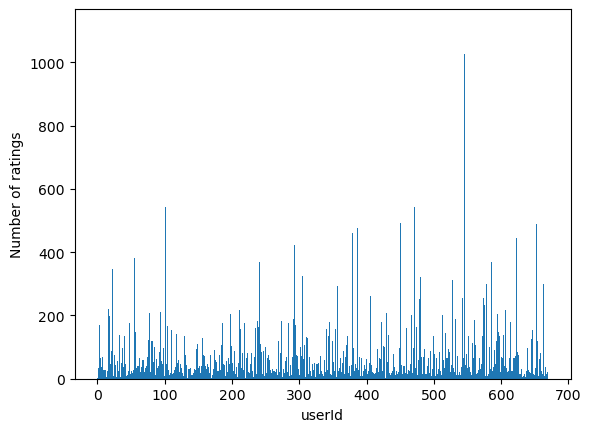

In [14]:
## Compare all ratings only with ratings with ratings >= 4 (highly rated)

nmovies = len(ratings['movieId'].unique())
print(f'Number of unique movies: {nmovies: d}')
avgn = len(ratings)/nmovies
print(f'Average number of ratings per movie: {avgn:.1f}')
ratings.hist('movieId', bins=nmovies, grid=False)
plt.xlabel('movieId')
plt.ylabel('Number of ratings')
plt.title('')
plt.show()

threshold = 4
ratings_high = ratings[ ratings['rating'] >= threshold ].copy()
nmovies_high = len(ratings_high['movieId'].unique())
print(f'Number of unique movies for high ratings: {nmovies_high: d}')
avgn_high = len(ratings_high)/nmovies_high
print(f'Average number of ratings per movie for high ratings: {avgn_high:.1f}')
ratings.hist('movieId', bins=nmovies_high, grid=False)
plt.xlabel('movieId')
plt.ylabel('Number of ratings')
plt.title('')
plt.show()

nusers = len(ratings['userId'].unique())
print(f'Number of unique users: {nusers: d}')
avgn = len(ratings)/nusers
print(f'Average number of ratings per users: {avgn:.1f}')
ratings.hist('userId', bins=nusers, grid=False)
plt.xlabel('userId')
plt.ylabel('Number of ratings')
plt.title('')
plt.show()

nusers_high = len(ratings_high['userId'].unique())
print(f'Number of unique users who give high ratings: {nusers_high: d}')
avgn_high = len(ratings_high)/nusers_high
print(f'Average number of high ratings per users: {avgn_high:.1f}')
ratings_high.hist('userId', bins=nusers_high, grid=False)
plt.xlabel('userId')
plt.ylabel('Number of ratings')
plt.title('')
plt.show()

In [15]:
## Summary statistics for ratings count from users

user_stats = ratings.groupby('userId')['movieId'].count().reset_index(name='user ratings count')
user_stats['user ratings count'].describe()

count     671.000000
mean      148.748137
std       230.812421
min        19.000000
25%        37.000000
50%        71.000000
75%       160.500000
max      2386.000000
Name: user ratings count, dtype: float64

In [16]:
## Summary statistics for high ratings count from users

user_stats = ratings_high.groupby('userId')['movieId'].count().reset_index(name='user ratings count')
user_stats['user ratings count'].describe()

count     671.000000
mean       76.670641
std       105.968076
min         1.000000
25%        20.000000
50%        41.000000
75%        88.500000
max      1113.000000
Name: user ratings count, dtype: float64

In [17]:
## Summary statistics for ratings count of movies

movies_stats = ratings.groupby('movieId')['userId'].count().reset_index(name='movie ratings count')
movies_stats['movie ratings count'].describe()

count    9025.000000
mean       11.059280
std        24.095433
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: movie ratings count, dtype: float64

In [18]:
## Summary statistics for high ratings count of movies

movies_stats = ratings_high.groupby('movieId')['userId'].count().reset_index(name='movie ratings count')
movies_stats['movie ratings count'].describe()

count    6141.000000
mean        8.377463
std        18.350359
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       274.000000
Name: movie ratings count, dtype: float64

From all of this we see that we still go plenty of data even if we only look at movies with ratings >= 4.
\
\
We also see that some users only like very few movies, a couple of users only like one movie. This may be a reaons to drop these users, but we don't want to exclude users that e.g. have very specific taste. Insted we would want to try to give these users a good recommendation though content-based methods.
\
\
We also see that in general, movies have very few ratings/high ratings. The average for higly rated movies is just above 8 ratings and only 25% of movies have more than 7 ratings. From this information any recommender system built will most suffer from serious popularity bias (which may or may not be good - would say it is good if it is not to much) and to restrict this bias it is better to keep all of the movies, even those who have only
been rated once.

In [19]:
## Free memory
del movies_stats, user_stats

## Final Data preparation

In [20]:
## From data exploratory above we can confidently say that highly rated movies have rating >= 4

threshold = 4
ratings_full = ratings.copy()
ratings_high = ratings[ ratings['rating'] >= threshold ].copy()

# Free memory
del ratings

## Utilities

In [38]:
ratings_full

,userId,movieId,rating
0,0,30,2.5
1,0,830,3.0
2,0,856,3.0
3,0,903,2.0
4,0,927,4.0
...,...,...,...
99999,670,4537,2.5
100000,670,4538,4.0
100001,670,4589,4.0
100002,670,4602,2.5


In [39]:
def getRating(userId, movieId):
    # Precondition: user with id userId has given movie with id movieId a rating
    # Getter for rating from user with userId and on movie with movieId
    return ratings_full[(ratings_full['userId'] == userId) & (ratings_full['movieId'] == movieId)]['rating'].values[0]


def getTitle(movieId):
    # Getter for title of movie with id movieId
    return movies[movies['movieId'] == movieId]['title'].values[0]

## Models

### Collaborative filtering

In [22]:
## Data set up

nmovies = len(movies['movieId'].unique())   # All movies, not just highly rated ones

# We will use an adjacency-list representation where for each user we have a list of movieIds that he has
# rated highly
rates_adj = ratings_high.groupby('userId')['movieId'].apply(list).reset_index(name='rates').sort_values('userId')

# "Binarize" adjecency-list reperesentation so that every list has the same number of items, in order to 
# use Cosine and Euclidean similarity
def binarize(row):
    # Encode list of movieIds to a list where indexes are movieIds and element m is 1 if user rates movie 
    # with movieId = m, otherwise it is 0
    movieIds = row[1]
    list_ = np.zeros(nmovies, dtype=int)
    list_[movieIds] = 1
    return list_


binarized = rates_adj.apply(binarize, axis=1)
rates_adj_binarized = pd.DataFrame({'userId': rates_adj['userId'], 'rates': binarized})

### User similarity

In [23]:
## Recommend movies by using similar users - Collaborative filtering

class Similarity(Enum):
    Jaccard = "Jaccard similarity"
    Cosine = "Cosine similarity"
    Euclidean = "Euclidean similarity"


def Jaccard_similarity(user1, user2):
    # Measure Jaccard similarity between two users by comparing movies they have rated highly
    intersection = len(set(rates_adj['rates'][user1]).intersection(set(rates_adj['rates'][user2])))
    union = len(set(rates_adj['rates'][user1]).union(set(rates_adj['rates'][user2])))
    return intersection/union


def Euclidean_similarity(user1, user2):
    # Measure Euclidean similarity between two users by comparing movies they have rated highly
    ratings1 = rates_adj_binarized['rates'][user1]
    ratings2 = rates_adj_binarized['rates'][user2]  
    return np.linalg.norm(ratings1-ratings2)
    

def Cosine_similarity(user1, user2):
    # Measure Cosine similarity between two users by comparing movies they have rated highly
    ratings1 = rates_adj_binarized['rates'][user1]
    ratings2 = rates_adj_binarized['rates'][user2]  
    return np.dot(ratings1, ratings2)/(np.linalg.norm(ratings1)*np.linalg.norm(ratings2))


def recommend_distance(userId, number=10, similarity=Similarity.Jaccard):
    # Recommend "number" of movies to user with id "userId" by using specific measure of "similarity"

    # If user has not given high ratings (i.e. not in rates_adj) then we can't make recommendations
    if(userId not in rates_adj['userId'].values):
        print(f'Can not make recommendations because user with userId=%d has given no ratings >=4' %(userId))
        return []

    # Type checking for similarity
    if not isinstance(similarity, Similarity):
        raise TypeError('similarity must be an instance of Similarity Enum')

    # Measure similarity between user with id "userId" and all other users
    if similarity == Similarity.Jaccard:
        similar = rates_adj['userId'].apply(lambda x: Jaccard_similarity(userId, x)).tolist()
    elif similarity == Similarity.Cosine:
        similar = rates_adj['userId'].apply(lambda x: Cosine_similarity(userId, x)).tolist()
    elif similarity == Similarity.Euclidean:
        similar = rates_adj['userId'].apply(lambda x: Euclidean_similarity(userId, x)).tolist()

    # Heuristic: 
    # Find "number" of movies from most 3 most similar user. If they have not highly rated "number" of movies we 
    # use 3 next most similar user, and so on
    # First recommend movies from 3 most similar users with rating 5.0 and sort by popularity, then with 
    # rating 4.5 and finally with rating 4.0

    high_ratings = [5.0, 4.5, 4.0]
    recommendations = []
    cnt = 0
    similar = np.argsort(similar)[:-1][::-1]   # Exlude ourselves and reverse
    i = 0
    j = 3   # Take three users a time
    while(i < len(similar)):
        similarIds = similar[i:j]
        i += j
        for rating in high_ratings:
            # movieIds of liked movies (with rating="rating") from 3 most similar users but not same movies 
            # as user has seen or same movies user has been previosly recommended
            movieIds = ratings_high[ (ratings_high['rating'] == rating) &
                                     (ratings_high['userId'].isin(similarIds)) & 
                                     (~ratings_high['movieId'].isin(ratings_full[ ratings_full['userId'] == userId ]['movieId'])) &
                                     (~ratings_high['movieId'].isin(recommendations))
                                ].sort_values('rating', ascending=False)['movieId'].unique()
            movieIds = movies[ movies['movieId'].isin(movieIds) ].sort_values('popularity', ascending=False)['movieId'].tolist()
            for movieId in movieIds:
                recommendations.append(movieId)
                cnt += 1
                if(cnt == number):
                    return [getTitle(x) for x in recommendations]

    return [getTitle(x) for x in recommendations]

### Frequent itemsets - Apriori

In [24]:
## Encode ratings where each row is a user and each column a movie so that element (u,m) is 1 if user u
## higly rates movie m, otherwise 0

# List of lists of movieIds that users rate highly ("baskets") - TransactionEncoder needs data in list of lists
ratings_ratings = ( ratings_high.groupby('userId')['movieId'].apply(list).reset_index(name='ratings')
                    .sort_values('userId')['ratings'].tolist() )

# Encode (one hot)
te = TransactionEncoder()
te_ary = te.fit_transform(ratings_ratings, sparse=True)
ratings_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

In [25]:
## Get almost all frequent itemsets (need to allow low support because most movies are rated few times as 
## seen in data exploration) of max size 3 and then calculate assosication rules for the itemsets 

# Memory is limited...
try:
    del frequent_itemsets, frequent_rules
except:
    pass

frequent_itemsets = fpgrowth(ratings_encoded, min_support=0.015, max_len=3, use_colnames=True)
frequent_rules = association_rules(frequent_itemsets, metric="lift", min_threshold = 1, support_only=False)

In [26]:
# Number of unique movies in frequent itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
tmp = frequent_itemsets[frequent_itemsets['length'] >= 2]['itemsets'].apply(tuple).values
freqmovies = [item for sublist in tmp for item in sublist]
print('#Unique movies in frequent itemsets:', len(np.unique(freqmovies)))

#Unique movies in frequent itemsets: 968


In [27]:
# Free memory
del ratings_ratings, te_ary, ratings_encoded, frequent_itemsets, tmp, freqmovies

In [28]:
## Clean frequent_rules table

# We are only interested in antecedents singletons and pairs, and consequents singletons
frequent_rules['antecedents lenght'] = frequent_rules['antecedents'].apply(lambda x: len(x))
frequent_rules['consequents lenght'] = frequent_rules['consequents'].apply(lambda x: len(x))
frequent_rules = frequent_rules[ (frequent_rules['antecedents lenght'] <= 2)
                & (frequent_rules['consequents lenght'] == 1) ]

# Want to sort movieIds inside pairs for convenience
frequent_rules['antecedents'] = frequent_rules['antecedents'].apply(sorted).apply(tuple)
frequent_rules['consequents'] = frequent_rules['consequents'].apply(tuple).apply(lambda x: int(x[0]))
frequent_rules.reset_index(inplace=True, drop=True)

In [29]:
def recommend_apriori(userId, number):
    # Recommend "number" of movies for user with id "userId" by using lift measurement from frequent
    # itemsets

    # If user has not given high ratings (i.e. not in rates_adj) then we can't make recommendations
    if(userId not in ratings_high['userId'].unique()):
        print(f'Can not make recommendations because user with userId=%d has given no ratings >=4' %(userId))
        return []

    # Remove movies user has seen (from ratings_full)
    candidates = frequent_rules[ ~frequent_rules['consequents'].isin(ratings_full[ratings_full['userId'] == userId]['movieId'].values) ].copy()

    # Find all antecedents itemsets that is a part of any 1-combination or 2-combination of the
    # movies that the user has seen and likes
    movieIds = ratings_high[ ratings_high['userId'] == userId ]['movieId'].unique()
    comb = [x for x in combinations(movieIds, 1)] + [x for x in combinations(movieIds, 2)]
    candidates = candidates[ candidates['antecedents'].isin(comb) ]
    candidates.sort_values('lift', ascending=False, inplace=True)
    
    # Remove duplicate consequents singletons - keep the one with highest lift
    candidates.drop_duplicates('consequents', keep='first', inplace=True)
    
    # Message to user if we can't recommend "numbers" movies to him
    if(number > len(candidates)):
        print('Not able to recommend', number, 'movies.', 'Only able to recommend', len(candidates),
                'movies:')
        
    # Take "number" movies with highest lift
    recommendations = [x for x in candidates['consequents'][:number].values.tolist()]

    return [getTitle(x) for x in recommendations]

### Movie similarity

In [30]:
## Create a df that has important movie description as a string of words - we use overview (without words
# such as "the", "and", ...), top 3 actors?, director, keywords, genre?

d = {'movieId': movies['movieId'].values, 'description': [""]*len(movies)}
movies_description = pd.DataFrame(data=d)
movies_description

## Create a long string with movie description where we use information such as overview, actors, directors
## keywords, etc.

for Id in movies_description['movieId']:
    description = ''

    # Get movie overview
    try:
        description += movies.loc[Id,'overview']
    except:
        continue

    # Get top 5 actors from movie
    for i in range(5):
        try: 
            description += ' ' + credits['cast'][Id][i]['name'].split()[-1]   # Only use last name of actors
        except:
            continue

    # Get directors
    for i in range(len(credits['crew'][Id])):
        if credits['crew'][Id][i]['department'] == 'Directing':
            description += ' ' + credits['crew'][Id][i]['name'].split()[-1]   # Only use last name of directors

    # Get genre
    for i in range(len(movies['genres'][Id])):
        description += ' ' + movies['genres'][Id][i]['name']

    # Get keywords
    for i in range(len(keywords['keywords'][Id])):
        description += ' ' + keywords['keywords'][Id][i]['name']

    movies_description.loc[Id, 'description'] = description 
    

movies_description.head()

,movieId,description
0,0,"Led by Woody, Andy's toys live happily in his ..."
1,1,When siblings Judy and Peter discover an encha...
2,2,A family wedding reignites the ancient feud be...
3,3,"Cheated on, mistreated and stepped on, the wom..."
4,4,Just when George Banks has recovered from his ...


In [31]:
# Vectorize movie descriptions
vectorizer = CountVectorizer(stop_words='english') # Remove stop words
matrix = vectorizer.fit_transform(movies_description['description'])

matrix.shape # (number of movies, total number of words in vectors)

(9025, 41951)

In [32]:
def recommend_content(userId,number):

    # If user has not given high ratings (i.e. not in rates_adj) then we can't make recommendations
    if(userId not in ratings_high['userId'].unique()):
        print(f'Can not make recommendations because user with userId=%d has given no ratings >=4' %(userId))
        return []
        
    n = 0
    i = 0
    recommendations_ids = []
    seen_movies = ratings_full[ratings_full['userId']==userId]['movieId'].tolist()
    liked_movies = ratings_high[ (ratings_high['userId'] == userId) ].sort_values('rating', ascending=False)['movieId'].values
    while(n <= number): # While we haven't gotten n reccomendations
        movieId = liked_movies[i] # Id of liked film
        vec_id = matrix[movieId].toarray().T
        with np.errstate(divide='ignore',invalid='ignore'):
            cosine_similarity = np.divide(matrix.dot(vec_id).reshape((nmovies,)),
                norm(matrix,axis=1)) # Cosine similarity
            cosine_similarity[np.isnan(cosine_similarity)] = np.NINF
        for t in range(1,5): # Get 3 reccomended movies from each liked movie
            reccomended = np.argsort(cosine_similarity,axis=0)[-t]
            if(reccomended not in recommendations_ids and reccomended not in seen_movies):
                recommendations_ids.append(reccomended)
                n += 1     
        i += 1

    return [getTitle(idx) for idx in recommendations_ids][:number]

## Testing

In [33]:
# Can be hard to find a "numeric" measurement of how well the system can recommend movies
# One good way is just to to "human" testing, i.e. compare movies that the user likes with movies that we
# have recommended for the user

In [44]:
def recommend_for_user(userId,number):
    movieIds = ratings_full[ratings_full['userId'] == userId].sort_values('rating', ascending=False)['movieId'].values[:number]
    likedTitles = [getTitle(i) for i in movieIds]
    distance = recommend_distance(userId, number, similarity=Similarity.Jaccard)
    freq = recommend_apriori(userId,number)
    content = recommend_content(userId,number)
    appears_twice = list((set(distance) & set(freq)) or (set(distance) & set(content)) or (set(freq) & set(content)))
    print('Favourite movies for user %d\n'%(userId),likedTitles)
    print('\nSimilar users method:\n',distance)
    print('\nFrequent itemsets method:\n',freq)
    print('\nSimilar movies method:\n',content)
    print('\nAppears in atleast two methods:\n',appears_twice)

In [42]:
recommend_for_user(100,20)

Favourite movies for user 100
 ['Inception', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers', 'The Dark Knight', 'Raiders of the Lost Ark', 'Batman Begins', 'The Empire Strikes Back', 'The Matrix', 'Saving Private Ryan', 'Star Trek IV: The Voyage Home', 'Star Trek II: The Wrath of Khan', 'Indiana Jones and the Last Crusade', 'Back to the Future', 'The Lord of the Rings: The Return of the King', 'Aliens', 'Return of the Jedi', 'Terminator 2: Judgment Day', 'District 9', "Schindler's List", 'Star Trek']

Similar users method:
 ['The Avengers', 'Jurassic Park', 'Forrest Gump', 'The Silence of the Lambs', 'The Martian', 'Iron Man', 'Harry Potter and the Order of the Phoenix', 'E.T. the Extra-Terrestrial', 'Pulp Fiction', 'Back to the Future Part II', "The Hitchhiker's Guide to the Galaxy", 'Office Space', 'Meet the Fockers', 'The 40 Year Old Virgin', 'Harold & Kumar Go to White Castle', 'Star Wars: The Force Awakens', 'Harry Potter and the Half-

In [43]:
recommend_for_user(400,20)

Favourite movies for user 400
 ['Toy Story', 'Planet of the Apes', 'Alien³', 'Star Trek: First Contact', 'Star Trek II: The Wrath of Khan', 'Star Trek III: The Search for Spock', 'Star Trek IV: The Voyage Home', 'Men in Black', 'Star Wars', 'Godzilla', 'King Kong vs. Godzilla', 'The Fly', 'The Matrix', 'Groundhog Day', 'The Rocky Horror Picture Show', 'Phantasm', 'Spaceballs', 'Galaxy Quest', "Wayne's World", 'Close Encounters of the Third Kind']

Similar users method:
 ['The Spy Who Loved Me', 'Dune', 'Excalibur', 'Escape to Witch Mountain', 'Flubber', 'Outland', 'Pink Floyd: The Wall', 'Phantom of the Paradise', 'The Godfather', 'The Lord of the Rings: The Fellowship of the Ring', 'Shaft', 'The Fifth Element', 'DragonHeart', 'Gladiator', 'Terminator 2: Judgment Day', 'Braveheart', "Sgt. Pepper's Lonely Hearts Club Band", 'The Terminator', 'The Sixth Sense', 'Shrek']

Frequent itemsets method:
 ['Manhattan Murder Mystery', 'Deep Impact', 'Cinderella', 'Peter Pan', 'The Last Picture Sh